In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats
import networkx as nx
import os
import re
from collections import defaultdict
import matplotlib.cm as cm
from glob import glob
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/bridge"  

font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "mathtext.fontset": "custom",
    "mathtext.rm": "Helvetica",
    "mathtext.it": "Helvetica:italic",
    "mathtext.bf": "Helvetica:bold"
})

In [3]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/phasediag/results_04"

files = sorted(glob(os.path.join(data_dir, "freq_timeseries_mu_*.pkl")))

# Regex to extract parameters
pattern = re.compile(r"mu_([\d\.]+)_map_([\d\.]+)_trial_None\.pkl")

records = []
for f in files:
    m = pattern.search(os.path.basename(f))
    if not m:
        continue
    mu, map_val = map(float, m.groups())

    with open(f, "rb") as fh:
        data = pickle.load(fh)
    freq_timeseries = np.array(data) # (2,2,t)

    # average last 100 timepoints
    final = freq_timeseries[:, :, -100:].mean(axis=-1).flatten()

    # get ordering of values (descending)
    order = tuple(np.argsort(-final))  # e.g. (0, 3, 1, 2)
    records.append((mu, map_val, order))

In [4]:
gp_pairs = [(0,0), (0,1), (1,0), (1,1)]

def ordering_to_label(ordering):
    """Convert an ordering like (3,0,1,2) into a label like f_1^1 > f_0^0 > f_0^1 > f_1^0."""
    terms = []
    for idx in ordering:
        g, p = gp_pairs[idx]
        terms.append(f"$f_{{{g}}}^{{\\left({p}\\right)}}$")
    return " > ".join(terms)

/var/folders/8p/7dvyf8jj5778n86kw_n3hx2w0000gn/T/ipykernel_5438/4045428943.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap(cmap_name, len(visible_indices))


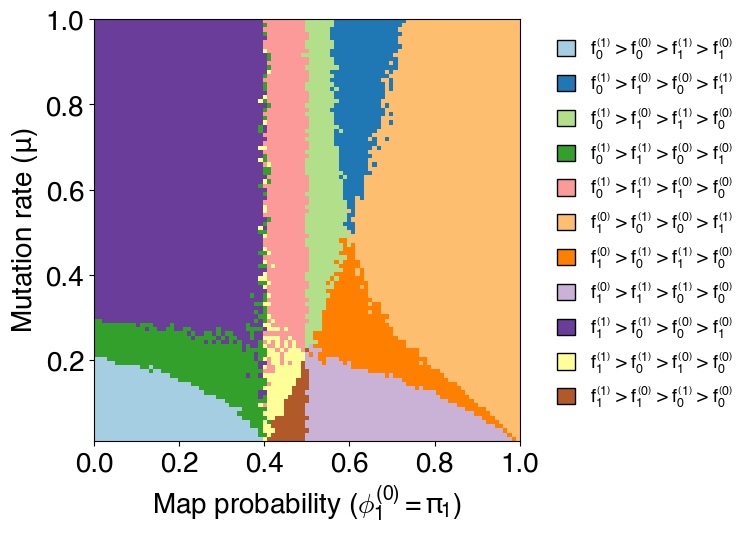

In [5]:
# --- Build sorted coordinate lists ---
mu_vals  = sorted(set(mu for mu, _, _ in records))
map_vals = sorted(set(map_val for _, map_val, _ in records))

# --- Map each (mu,map) to category index ---
unique_orders = sorted(set(order for _, _, order in records))
order_to_idx = {order:i for i,order in enumerate(unique_orders)}

grid = np.full((len(mu_vals), len(map_vals)), np.nan)
for mu, map_val, order in records:
    i = mu_vals.index(mu)       # μ → row (y-axis)
    j = map_vals.index(map_val) # map → column (x-axis)
    grid[i,j] = order_to_idx[order]

# --- Remove the bottom row (smallest μ) ---
grid = grid[1:, :]       # drop first row
mu_vals = mu_vals[1:]    # keep matching coordinate list

# --- Identify categories still present ---
visible_indices = np.unique(grid[~np.isnan(grid)]).astype(int)
visible_orders = [unique_orders[i] for i in visible_indices]
# visible_orders = [tuple(int(x) for x in t) for t in visible_orders]

# --- Create a reduced colormap with one unique color per visible ordering ---
cmap_name = "Paired" 
base_cmap = plt.cm.get_cmap(cmap_name, len(visible_indices))
restricted_cmap = mcolors.ListedColormap([base_cmap(i) for i in range(len(visible_indices))])

# --- Remap grid to compressed category indices ---
index_map = {old_i: new_i for new_i, old_i in enumerate(visible_indices)}
compressed_grid = np.full_like(grid, np.nan)
for old_i, new_i in index_map.items():
    compressed_grid[grid == old_i] = new_i

# --- Plot ---
plt.figure(figsize=(8,8))
im = plt.imshow(
    compressed_grid,
    origin="lower",
    extent=[min(map_vals), max(map_vals), min(mu_vals), max(mu_vals)],
    cmap=restricted_cmap,
    aspect="auto",
    interpolation="none"
)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("Map probability ($\phi_1^{(0)} = \pi_1$)")
plt.ylabel("Mutation rate ($\mu$)")

# --- Legend: show ordering tuples for each visible color ---
legend_elems = [
    Patch(
        facecolor = restricted_cmap(new_i),
        edgecolor='k',
        label=ordering_to_label(unique_orders[old_i])
    )
    for new_i, old_i in enumerate(visible_indices)
]

plt.legend(
    handles=legend_elems,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False,
    handlelength=1.0,
    handleheight=1.0,
    fontsize=13
)

ax = plt.gca()   # get current axes
for artist in ax.get_children():
    if hasattr(artist, "set_rasterized"):
        artist.set_rasterized(True)

outpath = "/Users/asapp/Documents/VAST/r4_figs/phasediag_04_rasterized.pdf"
plt.savefig(outpath, format="pdf", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [6]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/phasediag/results"

files = sorted(glob(os.path.join(data_dir, "freq_timeseries_mu_*.pkl")))

# Regex to extract parameters
pattern = re.compile(r"mu_([\d\.]+)_map_([\d\.]+)_trial_None\.pkl")

records = []
for f in files:
    m = pattern.search(os.path.basename(f))
    if not m:
        continue
    mu, map_val = map(float, m.groups())

    with open(f, "rb") as fh:
        data = pickle.load(fh)
    freq_timeseries = np.array(data) # (2,2,t)

    # average last 100 timepoints
    final = freq_timeseries[:, :, -100:].mean(axis=-1).flatten()

    # get ordering of values (descending)
    order = tuple(np.argsort(-final))  # e.g. (0, 3, 1, 2)
    records.append((mu, map_val, order))

/var/folders/8p/7dvyf8jj5778n86kw_n3hx2w0000gn/T/ipykernel_5438/2024665839.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_cmap = plt.cm.get_cmap(new_cmap, len(visible_indices))


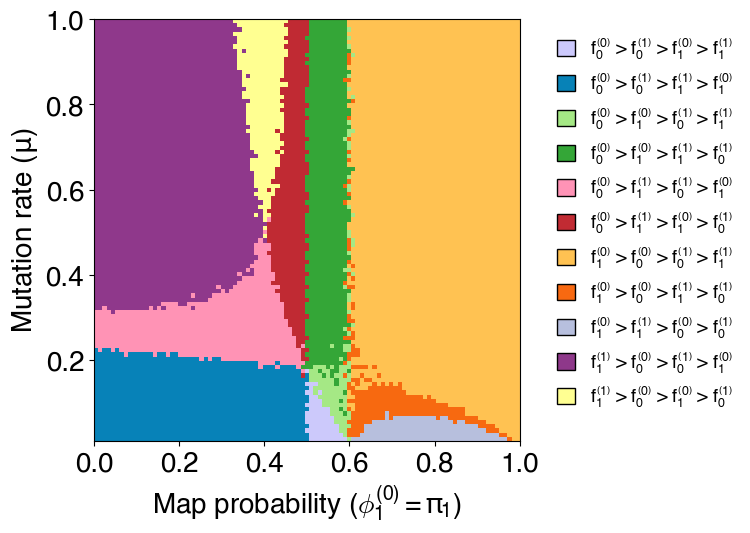

In [12]:
# --- Build sorted coordinate lists ---
mu_vals  = sorted(set(mu for mu, _, _ in records))
map_vals = sorted(set(map_val for _, map_val, _ in records))

# --- Map each (mu,map) to category index ---
unique_orders = sorted(set(order for _, _, order in records))
order_to_idx = {order:i for i,order in enumerate(unique_orders)}

grid = np.full((len(mu_vals), len(map_vals)), np.nan)
for mu, map_val, order in records:
    i = mu_vals.index(mu)       # μ → row (y-axis)
    j = map_vals.index(map_val) # map → column (x-axis)
    grid[i,j] = order_to_idx[order]

# --- Remove the bottom row (smallest μ) ---
grid = grid[1:, :]       # drop first row
mu_vals = mu_vals[1:]    # keep matching coordinate list

# --- Identify categories still present ---
visible_indices = np.unique(grid[~np.isnan(grid)]).astype(int)
visible_orders = [unique_orders[i] for i in visible_indices]
# visible_orders = [tuple(int(x) for x in t) for t in visible_orders]

# --- Create a reduced colormap with one unique color per visible ordering ---
def jitter_cmap(cmap_name="Paired", strength=0.02, seed=6):
    np.random.seed(seed)
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.linspace(0,1,cmap.N))
    
    jitter = strength * (np.random.rand(*colors.shape) - 0.5)
    
    new_colors = np.clip(colors + jitter, 0, 1)
    return mcolors.ListedColormap(new_colors)

new_cmap = jitter_cmap("Paired", strength=0.3)

base_cmap = plt.cm.get_cmap(new_cmap, len(visible_indices))
restricted_cmap = mcolors.ListedColormap([base_cmap(i) for i in range(len(visible_indices))])

# --- Remap grid to compressed category indices ---
index_map = {old_i: new_i for new_i, old_i in enumerate(visible_indices)}
compressed_grid = np.full_like(grid, np.nan)
for old_i, new_i in index_map.items():
    compressed_grid[grid == old_i] = new_i

# --- Plot ---
plt.figure(figsize=(8,8))
im = plt.imshow(
    compressed_grid,
    origin="lower",
    extent=[min(map_vals), max(map_vals), min(mu_vals), max(mu_vals)],
    cmap=restricted_cmap,
    aspect="auto",
    interpolation="none"
)

plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel("Map probability ($\phi_1^{(0)} = \pi_1$)")
plt.ylabel("Mutation rate ($\mu$)")

# --- Legend: show ordering tuples for each visible color ---
legend_elems = [
    Patch(
        facecolor = restricted_cmap(new_i),
        edgecolor='k',
        label=ordering_to_label(unique_orders[old_i])
    )
    for new_i, old_i in enumerate(visible_indices)
]

plt.legend(
    handles=legend_elems,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False,
    handlelength=1.0,
    handleheight=1.0,
    fontsize=13
)

ax = plt.gca()   # get current axes
for artist in ax.get_children():
    if hasattr(artist, "set_rasterized"):
        artist.set_rasterized(True)

outpath = "/Users/asapp/Documents/VAST/r4_figs/phasediag_06_rasterized.pdf"
plt.savefig(outpath, format="pdf", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

In [168]:
data_dir = "/Users/asapp/Documents/VAST/sim_results/phasediag/results_05"

files = sorted(glob(os.path.join(data_dir, "freq_timeseries_mu_*.pkl")))

# Regex to extract parameters
pattern = re.compile(r"mu_([\d\.]+)_map_([\d\.]+)_trial_None\.pkl")

records = []
for f in files:
    m = pattern.search(os.path.basename(f))
    if not m:
        continue
    mu, map_val = map(float, m.groups())

    with open(f, "rb") as fh:
        data = pickle.load(fh)
    freq_timeseries = np.array(data) # (2,2,t)

    # average last 100 timepoints
    final = freq_timeseries[:, :, -100:].mean(axis=-1).flatten()

    # get ordering of values (descending)
    order = tuple(np.argsort(-final))  # e.g. (0, 3, 1, 2)
    records.append((mu, map_val, order))

/var/folders/8p/7dvyf8jj5778n86kw_n3hx2w0000gn/T/ipykernel_81822/1195111552.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


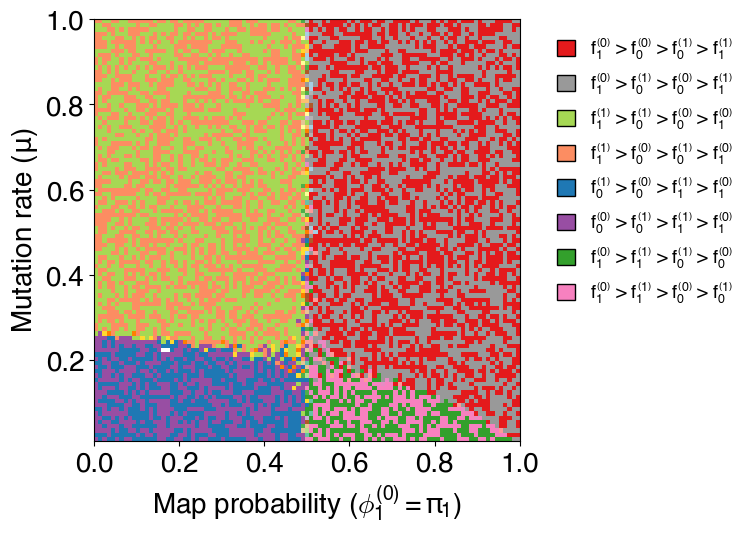

In [188]:
# --- Build sorted coordinate lists ---
mu_vals  = sorted(set(mu for mu, _, _ in records))
map_vals = sorted(set(map_val for _, map_val, _ in records))

# --- Map each (mu,map) to category index ---
unique_orders = sorted(set(order for _, _, order in records))
order_to_idx = {order:i for i,order in enumerate(unique_orders)}

grid = np.full((len(mu_vals), len(map_vals)), np.nan)
for mu, map_val, order in records:
    i = mu_vals.index(mu)       # μ → row (y-axis)
    j = map_vals.index(map_val) # map → column (x-axis)
    grid[i,j] = order_to_idx[order]

# --- Remove the bottom row (smallest μ) ---
grid = grid[1:, :]       # drop first row
mu_vals = mu_vals[1:]    # keep matching coordinate list

# --- Identify categories still present ---
visible_indices = np.unique(grid[~np.isnan(grid)]).astype(int)

# --- Count how many times each visible ordering appears ---
counts = {
    idx: np.sum(grid == idx)
    for idx in visible_indices
}

# --- Pick the 8 most frequent orderings ---
top8 = sorted(counts.keys(), key=lambda i: counts[i], reverse=True)[:8]

visible_orders = [unique_orders[i] for i in visible_indices]
# visible_orders = [tuple(int(x) for x in t) for t in visible_orders]

# --- Create a reduced colormap with one unique color per visible ordering ---
candidates = []
for cmap_name in [  "Set1", "Set2", "Paired"]:
    cmap = plt.cm.get_cmap(cmap_name)
    candidates.extend(cmap(np.linspace(0, 1, cmap.N)))


np.random.shuffle(candidates)

# Now extract only the first 24
colors = candidates[:24]
restricted_cmap = mcolors.ListedColormap(colors)

# --- Remap grid to compressed category indices ---
index_map = {old_i: new_i for new_i, old_i in enumerate(visible_indices)}
compressed_grid = np.full_like(grid, np.nan)
for old_i, new_i in index_map.items():
    compressed_grid[grid == old_i] = new_i

# --- Plot ---
plt.figure(figsize=(8,8))
im = plt.imshow(
    compressed_grid,
    origin="lower",
    extent=[min(map_vals), max(map_vals), min(mu_vals), max(mu_vals)],
    cmap=restricted_cmap,
    aspect="auto",
    interpolation="none"
)

plt.gca().set_aspect('equal', adjustable='box')


plt.xlabel("Map probability ($\phi_1^{(0)} = \pi_1$)")
plt.ylabel("Mutation rate ($\mu$)")

# --- Legend: show only the 8 most represented orderings ---
legend_elems = [
    Patch(
        facecolor=restricted_cmap(index_map[i]),     # new index
        edgecolor='k',
        label=ordering_to_label(unique_orders[i])    # original ordering label
    )
    for i in top8
]

plt.legend(
    handles=legend_elems,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=False,
    handlelength=1.0,
    handleheight=1.0,
    fontsize=13, 
)

ax = plt.gca()   # get current axes
for artist in ax.get_children():
    if hasattr(artist, "set_rasterized"):
        artist.set_rasterized(True)

outpath = "/Users/asapp/Documents/VAST/r4_figs/phasediag_05_rasterized.pdf"
plt.savefig(outpath, format="pdf", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()